In [21]:
# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vpeksj3o
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vpeksj3o
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=80547 sha256=7b6444fa1fb334f40cf05bde3bd9d76ccf4b5abe6da4ac77db9979afb87b305c
  Stored in directory: /tmp/pip-ephem-wheel-cache-gl0i7ie_/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [3]:
dataset = pd.read_csv('yeetFinal.csv')

In [5]:
# print(train_dataset.index)

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
len(train_dataset)

480

In [7]:
train_stats = train_dataset.describe()
train_stats.pop("shelf_life")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
temperature,480.0,5.336097e+01,3.584914e+00,40.000000,52.605112,53.949875,5.530326e+01,5.993939e+01
humidity,480.0,8.619044e+01,3.893193e+00,80.000000,82.931571,85.902256,8.899180e+01,9.500000e+01
top_ice_accepted,480.0,2.375000e-01,4.259951e-01,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
water_sprinkle_accepted,480.0,2.375000e-01,4.259951e-01,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
ethylene_ppm,480.0,3.286843e+00,2.302543e+00,0.010101,1.498747,2.989975,4.483709e+00,1.000000e+01
c02,480.0,1.418478e+06,2.082732e+06,0.000000,292105.263125,796491.228050,1.321930e+06,9.909090e+06
oxygen,480.0,4.569892e+05,2.959793e+05,50303.030000,182061.403475,439210.526300,7.168860e+05,1.000000e+06


In [8]:
train_labels = train_dataset.pop('shelf_life')
test_labels = test_dataset.pop('shelf_life')

In [9]:
print(len(train_dataset))
print(len(train_labels))
print(len(test_dataset))
print(len(test_labels))

480
480
120
120


In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [11]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0009)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 33,665
Trainable params: 33,665
Non-trainable params: 0
_________________________________________________________________


In [14]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

InternalError:  Blas GEMM launch failed : a.shape=(10, 7), b.shape=(7, 64), m=10, n=64, k=7
	 [[node dense/MatMul (defined at C:\Users\tharagesh\Anaconda3\envs\SSLab\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_274]

Function call stack:
keras_scratch_graph


In [ ]:
EPOCHS = 20

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

In [126]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
15,0.448345,0.557000,0.448345,0.466581,0.575652,0.466581,15
16,0.468489,0.561472,0.468489,0.506869,0.591147,0.506869,16
17,0.445370,0.545972,0.445370,0.556337,0.626372,0.556337,17
18,0.444355,0.546702,0.444355,0.536797,0.600602,0.536797,18
19,0.423752,0.532916,0.423752,0.473876,0.575886,0.473876,19


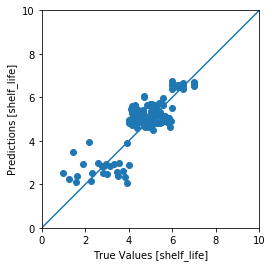

In [129]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [shelf_life]')
plt.ylabel('Predictions [shelf_life]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

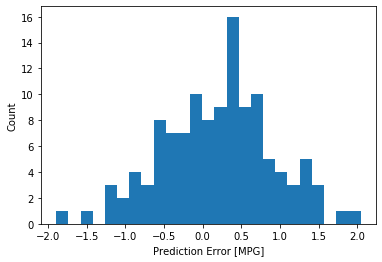

In [130]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [139]:
# testp = normed_test_data[:5]
# testy = test_labels[:5]
# test_predictions = model.predict(test)

testp = test_dataset[:5]
testy = test_labels[:5]
test_predictions = model.predict(test)
print(testp)
print(testy)
print(test_predictions)

    temperature   humidity  ...           c02       oxygen
3      52.58145  84.962406  ...  1.666667e+05  834912.2807
9      55.16792  87.318296  ...  2.087719e+05  504210.5263
11     54.42424  86.767680  ...  7.636363e+06  609090.9000
19     57.57576  90.000000  ...  4.545454e+06  218181.8000
23     54.63659  81.428571  ...  5.701754e+05  417543.8596

[5 rows x 7 columns]
3     4.651629
9     5.804511
11    2.272727
19    3.151515
23    5.634085
Name: shelf_life, dtype: float64
[[5.326337 ]
 [5.0503764]
 [2.1563349]
 [2.8603618]
 [5.1685867]]
